In [2]:
import numpy as np
from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from numpy import arange
from torch.optim import Adam 

In [3]:
def plot_hist(data, bins=10, xlabel='x', ylabel='Probability', title='', density=None):
    bins = np.concatenate((np.arange(bins) - 0.5, [bins - 1 + 0.5]))

    plt.figure()
    plt.hist(data, bins=bins, density=True)

    if density:
        plt.plot(density[0], density[1], label='distribution')
        plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [4]:

def compute_1d_distribution(seed = 100, samples = 50, dimension = 10):
    rand_state = np.random.RandomState(seed)
    x = 0.3 + rand_state.randn(samples) * 0.15
    y = 0.8 + rand_state.randn(samples) * 0.10
    mask = rand_state.rand(samples) < 0.5
    combined =  x * mask + y * (1 - mask)
    clipped = np.clip(combined, 0.0, 1.0)

    bins = np.linspace(0.0, 1.0, dimension)

    return np.digitize(clipped,bins=bins).astype(float)

class Histogram(nn.Module):
    def __init__(self, dimension=100):
        super(Histogram,self).__init__()
        self.dimension = dimension
        self.logits = nn.Parameter(torch.zeros(dimension))

    def nll(self, truth: torch.Tensor, index_start_at_zero = True):
        if index_start_at_zero == False:
            truth = truth - 1 

        truth_dim = truth.shape[0]

        logits = self.logits.unsqueeze(dim=0).repeat(truth_dim, 1)
        return F.cross_entropy(logits, truth.long())

    def nll_detailed(self, truth: torch.Tensor,index_start_at_zero = True):
        # bins index from 1 instead of 0
        if index_start_at_zero == False:
            truth = truth - 1 

        truth_dim = truth.shape[0]
        logits = self.logits.unsqueeze(dim=0).repeat(truth_dim,1)

        sm = logits.softmax(dim=1)
        one_hot_encode = F.one_hot(truth.long(), self.dimension)

        r = -torch.sum(sm.log() * one_hot_encode,dim=1)
        ce_long = r.mean(dim=0)

        return ce_long

    def get_density(self):
        total_points = 100
        points_per_bin = total_points // self.dimension

        x = np.linspace(0, self.dimension, total_points)

        with torch.no_grad():
            sm = F.softmax(self.logits, dim= 0).unsqueeze(dim=1)
            r = sm.repeat(1, points_per_bin )
            y = r.view(-1).numpy() # return 1-d view of the data
        return x, y


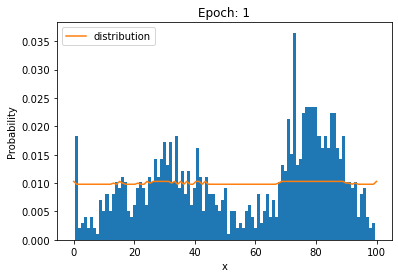

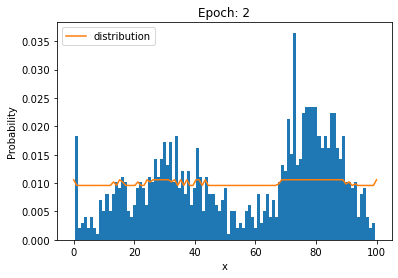

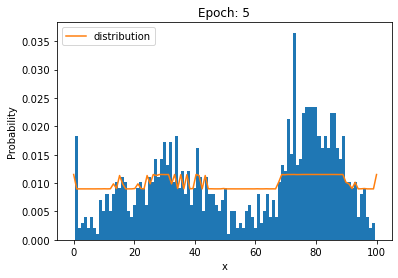

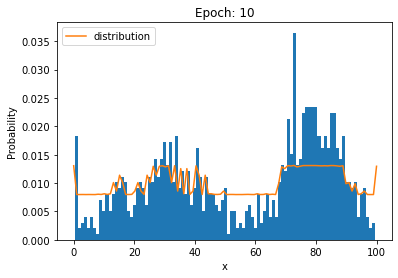

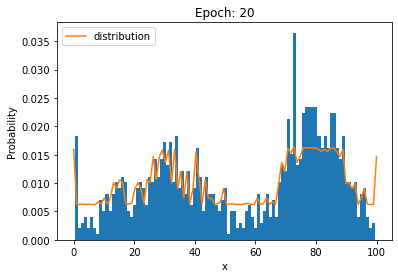

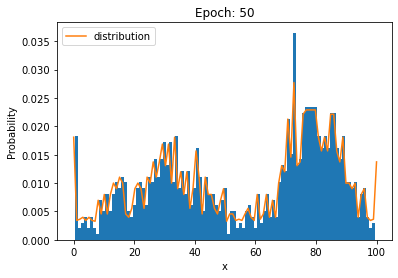

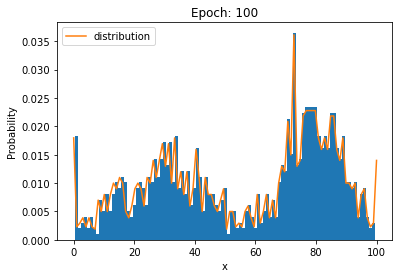

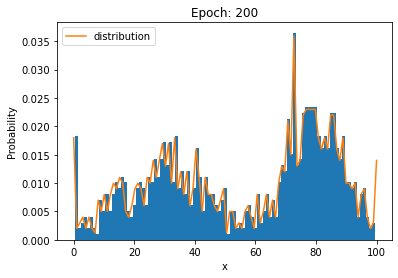

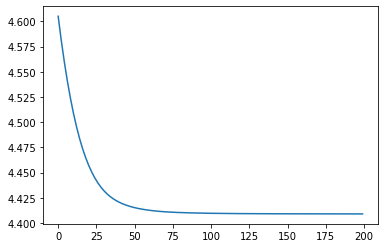

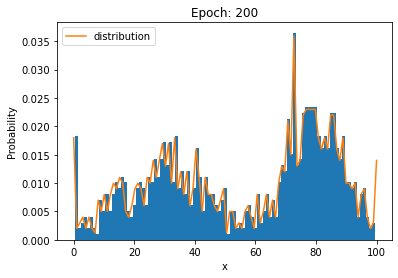

In [5]:
seed = 100
samples = 1000
dimension = 100
one_d_dist = compute_1d_distribution(seed=seed,samples = samples, dimension=dimension)

h = Histogram(dimension=dimension)

optimizer = Adam(h.parameters(), lr = 2.5e-2)

input_tensor = torch.Tensor(one_d_dist)

losses = []
epoch_count = 200

epoch_draw = [1,2,5,10,20,50,100,200]

for epoch in range(1, epoch_count+1):
    optimizer.zero_grad()
    loss = h.nll(input_tensor,False)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch in epoch_draw:
        x,y = h.get_density()
        plot_hist(one_d_dist,dimension,density=(x,y),title=f'Epoch: {epoch}')

plt.plot(arange(epoch_count), losses)

x,y = h.get_density()
plot_hist(one_d_dist,dimension,density=(x,y), title=f'Epoch: {epoch}')